# Dense and Sparse Matrices in Julia

This lecture will be about linear algebra in Julia, but almost everything we discuss will be equally applicable to other languages.  You almost never write your own basic linear-algebra routines these days, in any language — it is all about formulating your problem to exploit fast libraries, choosing the right algorithm, selecting good preconditioners (for iterative solvers) and so on.

That being said, there are a few nice things about linear-algebra that are relatively unusual in Julia, including a rich library of specialized matrix types, the ability to do linear-algebra with user-defined arithmetic type, and the ability to directly call low-level specialized routines from LAPACK and other libraries when needed.

In [1]:
using PyPlot, BenchmarkTools, Interact # some useful packages

"""
Like `@benchmark`, but returns only the minimum time in seconds,
similar to Julia's built-in `@elapsed` macro.
"""
macro belapsed(args...)
    b = Expr(:macrocall, Symbol("@benchmark"), map(esc, args)...)
    :(1e-9 * time(minimum($b)))
end

@belapsed

# Dense-matrix operations

In [2]:
# some important functions:
\, lu, lufact, chol, cholfact, qr, qrfact, eigvals, eig, svd

(\,lu,lufact,chol,cholfact,qr,qrfact,eigvals,eig,svd)

In [3]:
A = rand(3,3)
L, U, P = lu(A)

(
[1.0 0.0 0.0; 0.648716 1.0 0.0; 0.935312 -0.0101997 1.0],

[0.958996 0.0115501 0.607065; 0.0 0.850332 -0.251193; 0.0 0.0 -0.295036],

[2,1,3])

In [4]:
L

3×3 Array{Float64,2}:
 1.0        0.0        0.0
 0.648716   1.0        0.0
 0.935312  -0.0101997  1.0

In [5]:
F = lufact(A)

Base.LinAlg.LU{Float64,Array{Float64,2}}([0.958996 0.0115501 0.607065; 0.648716 0.850332 -0.251193; 0.935312 -0.0101997 -0.295036],[2,2,3],0)

In [6]:
b = rand(size(A,2))
x = F \ b
A*x - b

3-element Array{Float64,1}:
 -1.11022e-16
  0.0        
  0.0        

In [7]:
A \ b - x

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [8]:
A = rand(1000,1000)
@time lu(A)
@time lufact(A)
@time inv(A);

  0.028499 seconds (151 allocations: 22.912 MB, 12.68% gc time)
  0.027644 seconds (11 allocations: 7.637 MB, 47.14% gc time)
  0.104638 seconds (41.83 k allocations: 17.457 MB)


In [9]:
A = rand(1000,1000); A = A' * A # make a random symmetric positive-definite (SPD) matrix
@time lufact(A)
@time cholfact(A) # Cholesky factorization

  0.015929 seconds (11 allocations: 7.637 MB, 27.94% gc time)
  0.058356 seconds (32.39 k allocations: 8.998 MB)


Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[18.3833 14.3733 … 13.5096 13.3865; 0.0 12.3121 … 4.89393 4.92572; … ; 0.0 0.0 … 0.365252 -0.0811817; 0.0 0.0 … 0.0 0.462316]

In [110]:
@time cholfact(A)
@time sqrtm(A);

  0.000007 seconds (11 allocations: 432 bytes)
  0.000074 seconds (36 allocations: 6.984 KB)


In [40]:
A = rand(3,3)
qr(A)

(
[-0.962417 0.260478 -0.0768464; -0.117588 -0.654742 -0.74665; -0.2448 -0.709552 0.660764],

[-0.981424 -0.386922 -0.765385; 0.0 -1.04147 -0.740964; 0.0 0.0 0.413471])

In [42]:
A = rand(1000,1000)
@time qr(A)
@time qrfact(A);

  0.132713 seconds (2.03 k allocations: 31.099 MB, 2.93% gc time)
  0.044223 seconds (21 allocations: 8.179 MB, 4.88% gc time)


In [17]:
A = rand(1000,1000)
@time eigvals(A)
@time eig(A)

  1.136806 seconds (40 allocations: 7.941 MB, 0.42% gc time)
  2.340449 seconds (85 allocations: 30.831 MB, 0.07% gc time)


(Complex{Float64}[500.137+0.0im,9.27188+0.0im,8.9897+2.48363im,8.9897-2.48363im,7.4891+5.54544im,7.4891-5.54544im,5.80833+6.91194im,5.80833-6.91194im,5.58715+7.09777im,5.58715-7.09777im  …  -0.728402+0.32573im,-0.728402-0.32573im,0.668755+0.296028im,0.668755-0.296028im,-0.626136+0.262525im,-0.626136-0.262525im,0.280366+0.577733im,0.280366-0.577733im,0.246451+0.386541im,0.246451-0.386541im],
Complex{Float64}[-0.0319801+0.0im -0.0104509+0.0im … 0.00840477+0.0117568im 0.00840477-0.0117568im; -0.0314271+0.0im 0.00673969+0.0im … 0.00594426+0.00502358im 0.00594426-0.00502358im; … ; -0.0314786+0.0im -0.00140958+0.0im … -0.0813313+0.00960837im -0.0813313-0.00960837im; -0.0319455+0.0im -0.0299634+0.0im … -0.0450451+0.011183im -0.0450451-0.011183im])

In [21]:
A = rand(1000,1000); A = A + A'
@time eigvals(Symmetric(A));

  0.164019 seconds (26 allocations: 7.989 MB)


## Linear algebra with weird types

In [69]:
A = [1//2 1//3
     3//4 5//6]

2×2 Array{Rational{Int64},2}:
 1//2  1//3
 3//4  5//6

In [71]:
A \ [3, 4]

2-element Array{Rational{Int64},1}:
  7//1
 -3//2

In [79]:
@which lufact!(copy(A), Val{true})

lufact!(A::Union{Base.ReshapedArray{T<:Any,2,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N<:Any}}},DenseArray{T<:Any,2},SubArray{T<:Any,2,A<:Union{Base.ReshapedArray{T<:Any,N<:Any,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N<:Any}}},DenseArray},I<:Tuple{Vararg{Union{Base.AbstractCartesianIndex,Colon,Int64,Range{Int64}},N<:Any}},L<:Any}}, pivot::Union{Type{Val{false}},Type{Val{true}}}) at linalg/lu.jl:22

In [86]:
factorial(big(100))

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

In [90]:
setprecision(BigFloat, 1000)
BigFloat(pi)

3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446095505822317253594081284811174502841027019385211055596446229489549303819644288109756659334461284756482337867831652712019091456485669234603486104543266482133936072602491412736

In [93]:
lufact(BigFloat.(A))[:L]

2×2 Array{BigFloat,2}:
 1.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000      …  0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
 6.66666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666698e-01     1.000000000000000000000000000000000000000000

Computing eigenvalues is not yet possible ([issue #5429](https://github.com/JuliaLang/julia/issues/5429)), however:

In [94]:
eigvals(BigFloat.(A))

LoadError: MethodError: no method matching eigvals!(::Array{BigFloat,2}; permute=true, scale=true)[0m
Closest candidates are:
  eigvals!{T<:Union{Float32,Float64}}([1m[31m::SymTridiagonal{T<:Union{Float32,Float64}}[0m) at linalg/tridiag.jl:153[1m[31m got unsupported keyword arguments "permute", "scale"[0m
  eigvals!{T<:Union{Float32,Float64}}([1m[31m::SymTridiagonal{T<:Union{Float32,Float64}}[0m, [1m[31m::UnitRange{T<:Real}[0m) at linalg/tridiag.jl:159[1m[31m got unsupported keyword arguments "permute", "scale"[0m
  eigvals!{T<:Union{Float32,Float64}}([1m[31m::SymTridiagonal{T<:Union{Float32,Float64}}[0m, [1m[31m::Real[0m, [1m[31m::Real[0m) at linalg/tridiag.jl:166[1m[31m got unsupported keyword arguments "permute", "scale"[0m
  ...[0m

It turns out that computing eigenvalues is (provably) *much* harder than LU or QR factorization, because all eigenvalue computation (for $5\times5$ or bigger matrices) is necessarily an *iterative process* that converges towards the eigenvalues but never exactly reaches them (although we can get them to any desired precision).

The most common iterative process that is used for this is the [QR algorithm](https://en.wikipedia.org/wiki/QR_algorithm): Basically, you compute $A=QR$ and form $RQ$ over and over again (with lots of tricks to accelerate the process that aren't reproduced here):

In [105]:
A = rand(5,5); A = A + A'
B = copy(A)

5×5 Array{Float64,2}:
 0.875568  1.36593  1.26422  0.167304  1.5971  
 1.36593   1.10181  1.20797  1.5869    1.17239 
 1.26422   1.20797  1.90273  1.1621    1.80949 
 0.167304  1.5869   1.1621   0.052751  0.955859
 1.5971    1.17239  1.80949  0.955859  1.49302 

In [106]:
for i=1:1000
    Q,R = qr(B)
    B = R*Q
end
B

5×5 Array{Float64,2}:
 6.23446   5.25944e-16  -4.20247e-16    1.98817e-16   1.19798e-16
 0.0      -1.48128       5.53758e-16    6.35282e-16   6.08973e-16
 0.0       0.0           0.63742        1.46408e-16  -5.35772e-17
 0.0       0.0          -2.36997e-253   0.356328     -2.67675e-16
 0.0       0.0           4.17095e-299  -2.77843e-47  -0.321036   

It converged to a *diagonal matrix of the eigenvalues*!

In [107]:
eigvals(A)

5-element Array{Float64,1}:
 -1.48128 
 -0.321036
  0.356328
  0.63742 
  6.23446 

## Scaling

In [22]:
BLAS.set_num_threads(1) # don't want multi-threading to confuse our comparisons

In [23]:
A = rand(100,100)
t100 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
        @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
 0.000168492
 0.000919532
 0.0166672  
 0.0307146  
 0.018152   

In [24]:
t100 / t100[1] # time scaled by LU factorization time

5-element Array{Float64,1}:
   1.0    
   5.45742
  98.9197 
 182.291  
 107.732  

In [25]:
A = rand(1000,1000)
t1000 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
         @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
 0.0243751
 0.106795 
 1.54013  
 3.25038  
 0.819625 

In [26]:
t1000 / t1000[1]

5-element Array{Float64,1}:
   1.0    
   4.38134
  63.1846 
 133.349  
  33.6255 

In [27]:
t1000 ./ (t100 * 10^3)

5-element Array{Float64,1}:
 0.144666 
 0.116141 
 0.092405 
 0.105825 
 0.0451534

So much for $n^3$ scaling?   But maybe this is some kind of overhead that affects
small matrices, so we could compare to matrices of a more similar size?

In [28]:
A = rand(2000,2000)
t2000 = [@belapsed(lufact($A), evals=1), @belapsed(qrfact($A), evals=1), 
         @belapsed(eigvals($A), evals=1), @belapsed(eig($A), evals=1), @belapsed(svd($A), evals=1)]

5-element Array{Float64,1}:
  0.165642
  0.611513
  7.14818 
 17.6346  
  5.68343 

In [29]:
t2000 ./ (t1000 * 2^3)

5-element Array{Float64,1}:
 0.849443
 0.715753
 0.58016 
 0.678175
 0.866773

Okay, this is closer to $n^3$ scaling, at least, though it is still doing slightly better than it "should".   (I wonder if it is using multiple threads even though I told it not to?)

Now, to scale from this to solving a $200000 \times 200000$ system of equations should require:

In [30]:
t1000[1] * 1000^3 / 86400 # scale by 100^3 and divide by seconds/day

282.1188657407408

Yikes, almost 2 days.  Worse, we run out of memory before we run out of time:

In [31]:
sizeof(Float64) * 1e6^2 / 2^30 # size in GB

7450.580596923828

I don't have 300GB of RAM on my laptop!   You **often run out of memory before you run out of time** in large matrix problems.

And yet, we *will* solve such a system of equations, below, in less than 2 seconds with less than 1GB of memory.   The key is that *really* large systems of equations usually have some structure that you can exploit, the most common of which is *sparsity*.

# Sparse matrices

See accompanying [nested dissection and sparse matrices](Nested-Dissection.ipynb) notebook.

## Example: Vibrating modes of a drum

As an example, let's consider $\hat{A} = -\nabla\cdot c\nabla$ for some $c(\vec{x}) > 0$, which is self-adjoint and positive-definite for any finite domain $\Omega$ with Dirichlet boundary conditions $u|_{\partial\Omega}=0$ and the usual inner product $\langle u, v \rangle = \int_\Omega \bar{u} v$.

(This is an example taken from the class [18.303: Linear Partial Differential Equations](http://math.mit.edu/~stevenj/18.303/) at MIT.)

We'll define the finite-difference discretization by allowing the user to pass
in 1d arrays `x` and `y` of the $x$ and $y$ coordinates used in the
discretization (possibly nonuniformly spaced!), *including* the coordinates of the endpoints where $u$ is zero.  We'll also allow the user to pass in an arbitrary *function* $c(x,y)$ that we'll evaluate on the grid as needed, defaulting to `c=1`:

In [36]:
# compute the first-derivative finite-difference matrix
# for Dirichlet boundaries, given a grid x[:] of x points
# (including the endpoints where the function = 0!).
function sdiff1(x)
    N = length(x) - 2
    dx1 = Float64[1/(x[i+1] - x[i]) for i = 1:N]
    dx2 = Float64[-1/(x[i+1] - x[i]) for i = 2:N+1]
    spdiagm((dx1,dx2), (0,-1), N+1, N)
end

flatten(X) = reshape(X, length(X))

# compute the -∇⋅ c ∇ operator for a function c(x,y)
# and arrays x[:] and y[:] of the x and y points,
# including the endpoints where functions are zero
# (i.e. Dirichlet boundary conditions).
function Laplacian(x, y, c = (x,y) -> 1.0)
    Dx = sdiff1(x)
    Nx = size(Dx,2)
    Dy = sdiff1(y)
    Ny = size(Dy,2)
    
    # discrete Gradient operator:
    G = [kron(speye(Ny), Dx); kron(Dy, speye(Nx))]
    
    # grids for derivatives in x and y directions
    x′ = [0.5*(x[i]+x[i+1]) for i = 1:length(x)-1]
    y′ = [0.5*(y[i]+y[i+1]) for i = 1:length(y)-1]
    
    # evaluate c(x)
    C = spdiagm([ flatten(Float64[c(X,Y) for X in x′, Y in y[2:end-1]]);
                  flatten(Float64[c(X,Y) for X in x[2:end-1], Y in y′]) ])
    
    return G' * C * G # -∇⋅ c ∇
end

Laplacian (generic function with 2 methods)

Now, let's consider the usual $-\nabla^2$ operator, but use an oddly shaped domain, using the trick  of defining a discretization over a box and then taking a subset of rows and columns that are inside our domain.

We'll define an odd spiral-shaped domain as the intersection of the box $[-1,1]\times[-1,1]$ with the region where a [level-set function](https://en.wikipedia.org/wiki/Level_set_method) $\varphi(x,y)$ is $>0$.

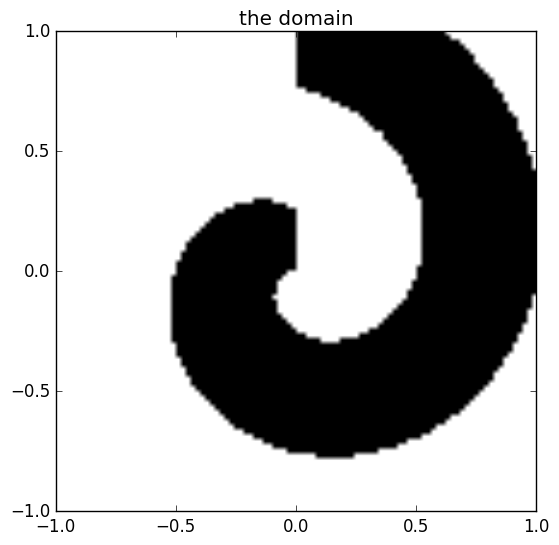

PyObject <matplotlib.text.Text object at 0x320234550>

In [37]:
N = 100
x = linspace(-1,1,N+2)[2:end-1]
y = x'  # a row vector
r = sqrt(x.^2 .+ y.^2)     # use broadcasting (.+) to make Nx x Ny matrix of radii
θ = broadcast(atan2, y, x) # and angles
φ = exp(-(r - θ*0.5/π - 0.5).^2 / 0.3^2) - 0.5
imshow(φ .> 0, extent=[-1,1,-1,1], cmap="binary")
title("the domain")

Now we'll compute the eigenfunctions.  We'll use the [Interact package](https://github.com/JuliaLang/Interact.jl) to interactively decide which eigenvalue to plot.

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(10, nactions=1),"which_eig",10,"10",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",2=>"2",16=>"16",11=>"11",7=>"7",9=>"9",10=>"10",19=>"19",17=>"17",8=>"8"…)),Any[],Any[],true,"horizontal")

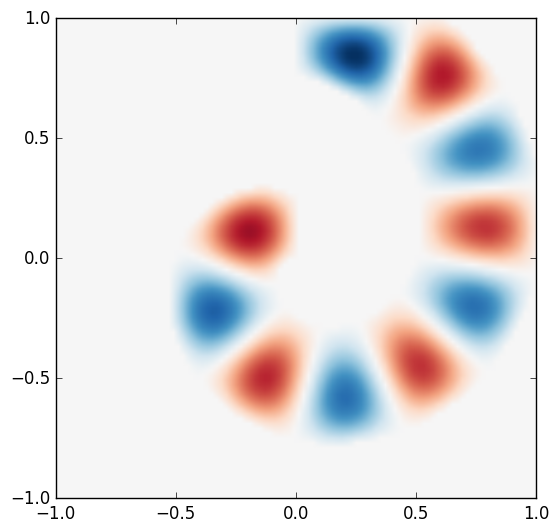

In [42]:
x0 = linspace(-1,1,N+2) # includes boundary points, unlike x
Abox = Laplacian(x0, x0, (x,y) -> 1.0);
i = find(φ .> 0)
A = Abox[i,i]
u = zeros(N,N)
λ, X = eigs(A, nev=20, which=:SM);

f = figure()
@manipulate for which_eig in 1:20
    withfig(f) do
        u[i] = X[:,which_eig]
        umax = maxabs(u)
        imshow(u, extent=[-1,1,-1,1], vmin=-umax,vmax=+umax, cmap="RdBu")
    end
end

## Example: Helmholtz solver

The following code solves a **scalar Helmholtz** equation

$$
\left[ -\nabla^2 - \omega^2 \varepsilon(x,y) \right] u = f(x,y)
$$

For example, this equation corresponds to *2d electromagntic waves* (with "natural" $c=1$ units) where $\varepsilon$ is the relative permittivity, $\omega$ is the frequency, $u$ is the electric-field component $E_z$, and $f$ is an electric-current density in the $z$ direction.

We discretize this into a matrix equation $Au=f$ with a "staggered" finite-difference grid (this is an [FDFD method](https://en.wikipedia.org/wiki/Finite-difference_frequency-domain_method)) with `resolution` pixels per unit distance (usually chosen to be at least 10 pixels per wavelength $\lambda = 2\pi/\omega$).   We solve it in a finite $L_x \times L_y$ box, with [PML](https://en.wikipedia.org/wiki/Perfectly_matched_layer) of thickness `dpml` around the exterior to absorb outgoing waves.  The user specifies
$\varepsilon(x,y)$ by passing a *function* argument, where $(0,0)$ is the coordinate at the center of the computational cell.

There is a nice trick to assemble the `A` matrices via smaller "1d" discretizations via [Kronecker products](https://en.wikipedia.org/wiki/Kronecker_product).

In [33]:
"""
Return `(A,Nx,Ny,x,y)` for the 2d Helmholtz problem.
"""
function Helmholtz2d(Lx, Ly, ε, ω; dpml=2, resolution=20, Rpml=1e-20)
    # PML σ = σ₀ x²/dpml², with σ₀ chosen so that
    # the round-trip reflection is Rpml:
    σ₀ = -log(Rpml) / (4dpml/3)
    
    M = round(Int, (Lx+2dpml) * resolution)
    N = round(Int, (Ly+2dpml) * resolution)
    dx = (Lx+2dpml) / (M+1)
    dy = (Ly+2dpml) / (N+1)
    x = (1:M) * dx - Lx/2 - dpml # x grid, centered
    y = (1:N) * dy - Ly/2 - dpml # y grid, centered
    
    # 1st-derivative matrix
    x′ = ((0:M) + 0.5)*dx # 1st-derivative grid points
    y′ = ((0:N) + 0.5)*dy # 1st-derivative grid points
    ox = ones(M)/dx
    oy = ones(N)/dy
    σx = Float64[ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Lx+dpml ? σ₀*(ξ-(Lx+dpml))^2 : 0.0 for ξ in x′]
    σy = Float64[ξ < dpml ? σ₀*(dpml-ξ)^2 : ξ > Ly+dpml ? σ₀*(ξ-(Ly+dpml))^2 : 0.0 for ξ in y′]
    Dx = spdiagm(1./(1+(im/ω)*σx)) * spdiagm((-ox,ox),(-1,0),M+1,M)
    Dy = spdiagm(1./(1+(im/ω)*σy)) * spdiagm((-oy,oy),(-1,0),N+1,N)
    Ix = speye(M)
    Iy = speye(N)
    return (kron(Ix, Dy.'*Dy) + kron(Dx.'*Dx, Iy) -
            spdiagm(reshape(Complex128[ω^2 * ε(ξ, ζ) for ζ in y, ξ in x], length(x)*length(y))),
            M, N, x, y)
end

Helmholtz2d

Let's set up a scattering problem with a cylindrical scatterer (ε=12 inside a diameter-1 cylinder in the center, and ε=1 elsewhere, with a wavelength $2\pi/\omega$ of 1):

In [34]:
A, Nx, Ny, x, y = Helmholtz2d(20,20, (x,y) -> hypot(x,y) < 0.5 ? 12 : 1, 2π)
size(A), nnz(A) / size(A,1)

((230400,230400),4.991666666666666)

For the right-hand side `b`, let's use a "point" source on one side.
We'll use the `reshape` function to convert between 2d arrays and
column vectors for solving with `A`.  Note that the solution is complex, since it corresponds physically to an oscillating solution $u(x,y)e^{-i\omega t}$ and $u$ has a phase angle due to the absorbing boundary layers (which make `A` non-Hermitian); we'll just plot the real part.

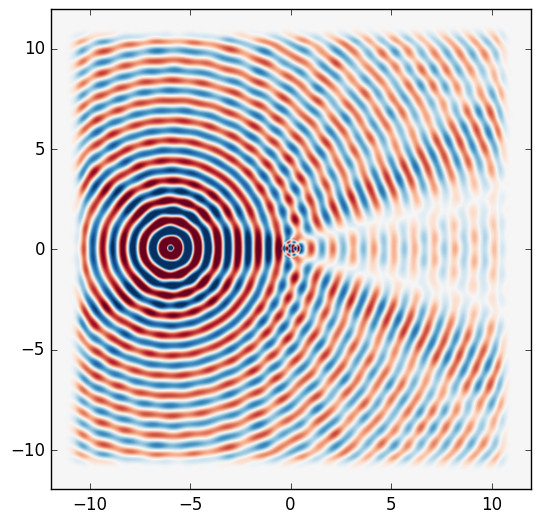

  3.066441 seconds (620.38 k allocations: 658.586 MB, 5.20% gc time)


PyObject <matplotlib.image.AxesImage object at 0x3202ac790>

In [35]:
b = zeros(Nx,Ny)
b[Nx÷2, Ny÷4] = 1
@time u = reshape(A \ reshape(b, Nx*Ny), Nx, Ny)
s = maxabs(real(u)) / 10
imshow(real(u), cmap="RdBu", vmin=-s, vmax=s,
       extent=(minimum(x),maximum(x),minimum(y),maximum(y)))

We solved a $200000\times200000$ matrix problem in about 2 seconds, and less than 1GB of memory.  Pretty good!

# Special sparse matrices in Julia

`sparse` and similar functions can store *any* sparse matrix, storing only the nonzero entries.   However, there are certain special patterns of nonzero entries that can be solved *much* more efficiently, and Julia provides specialized types to store and work with such matrices.  The most important four are:

In [20]:
SymTridiagonal, Diagonal, Tridiagonal, Bidiagonal

(SymTridiagonal{T},Diagonal{T},Tridiagonal{T},Bidiagonal{T})

For example, let's try it out on a famous symmetric positive-definite tridiagonal matrix, the discrete Laplacian (1d, unlike the 2d examples above):

In [21]:
n = 5
L = diagm(ones(n)*2) - diagm(ones(n-1),-1) - diagm(ones(n-1), 1)

5×5 Array{Float64,2}:
  2.0  -1.0   0.0   0.0   0.0
 -1.0   2.0  -1.0   0.0   0.0
  0.0  -1.0   2.0  -1.0   0.0
  0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0   0.0  -1.0   2.0

In [43]:
n = 1000
L = diagm(ones(n)*2) - diagm(ones(n-1),-1) - diagm(ones(n-1), 1)
b = rand(n)
@belapsed($L \ $b, evals=1) / @belapsed($(sparse(L)) \ $b, evals=1)

95.91323369107975

In [23]:
@belapsed($(sparse(L)) \ $b, evals=1) / @belapsed($(Tridiagonal(L)) \ $b, evals=1)

8.311553613197095

In [24]:
@belapsed($(sparse(L)) \ $b, evals=1) / @belapsed($(SymTridiagonal(L)) \ $b, evals=1)

16.327018221310485

The `Tridiagonal` solver was 8 times faster than the general sparse solver, and the `SymTridiagonal` solver gained us another factor of two.

# Iterative solvers

Unfortunately, sparse-direct solvers like those we are using above have two limitations:

* They only work **if the matrix is sparse**.  There are lots of problems where $A$ has some special structure that lets you compute $A*x$ quickly, e.g. by FFTs, and avoid storing the whole matrix, but for which $A$ is not sparse.

* They **scale poorly** if the sparse matrix comes from a **3d grid or mesh**.  For an $s$-element 1d mesh with $n=s$ degrees of freedom, they have $O(s)$ complexity.  For an $s \times s$ 2d mesh with $n=s^2$ degrees of freedom, they take $O(n \log n)$ operations and require $O(n)$ storage.   But for a 3d $s\times s\times s$ mesh with $n = s^3$, they take $O(n^2)$ operations and require $O(n^{4/3})$ storage (and you often run out of storage before you run out of time).

The alternative is an **iterative solver**, in which you supply an initial guess for the solution $x$ (often just $x=0$) and then it *iteratively improves* the guess, converging (hopefully) to the solution $A^{-1} b$, while using *only* matrix-vector operations $Ax$.

Iterative solvers are the method of choice (or, more accurately, of necessity) for the very largest problems, but they have their downsides.  There are *many iterative solver algorithms*, and you have to know a little bit to pick the best one.  They *may not converge at all* for non-symmetric $A$, and in any case may *converge very slowly*, unless you provide a "magic" matrix called a *preconditioner* that is specific to your problem. (It is often a research problem in itself to find a good preconditioner!)

## Toy example: Steepest-descent algorithm

If $A$ is a **real-symmetric positive-definite** matrix, then solving $Ax = b$ is equivalent to minimizing the function:

$$
f(x) = x^T A x - x^T b - b^T x
$$

(Just compute $\nabla f = \cdots = Ax - b$, which equals zero at the minimum.  The definiteness of $A$ means that the function $f$ is convex, so there is exactly one global minimum.)

One of the simplest iterative algorithms is just to **go downhill**: minimize $f(x + \alpha d)$ over $\alpha$, where $d$ is the downhill direction $-\nabla f = b - Ax = r$, where $r$ is called the *residual*.  We can perform this *line minimization* analytically for this $f$, for an arbitrary $d$, to find $\alpha = d^T r / d^T A d$.

The steepest-descent algorithm simply performs this downhill line-minimization repeatedly, starting at an initial guess `x` (typically just `x=0`), e.g. stopping when the norm of the residual is less than some tolerance times the norm of `b`.

In [46]:
function SD(A, b, x=zeros(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    Ad = zeros(r) # allocate space for Ad
    for i = 1:maxiters
        d = r # use the steepest-descent direction
        A_mul_B!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

SD (generic function with 2 methods)

In [111]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = SD(A, b, maxiters=1000)
length(rnorm), rnorm[end]/norm(b)

(1001,0.3128610451917836)

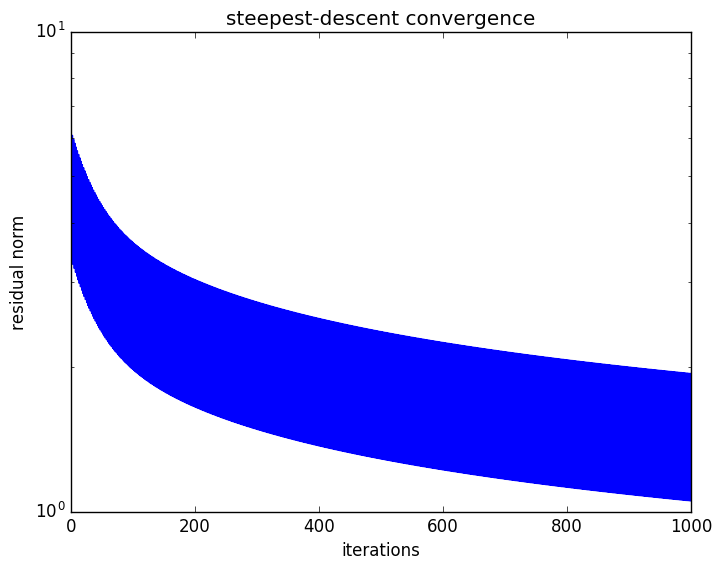

PyObject <matplotlib.text.Text object at 0x32b6d5e90>

In [112]:
semilogy(rnorm)
title("steepest-descent convergence")
ylabel("residual norm")
xlabel("iterations")

To see what's going on, let's try a $2\times2$ matrix where we can easily visualize the progress.

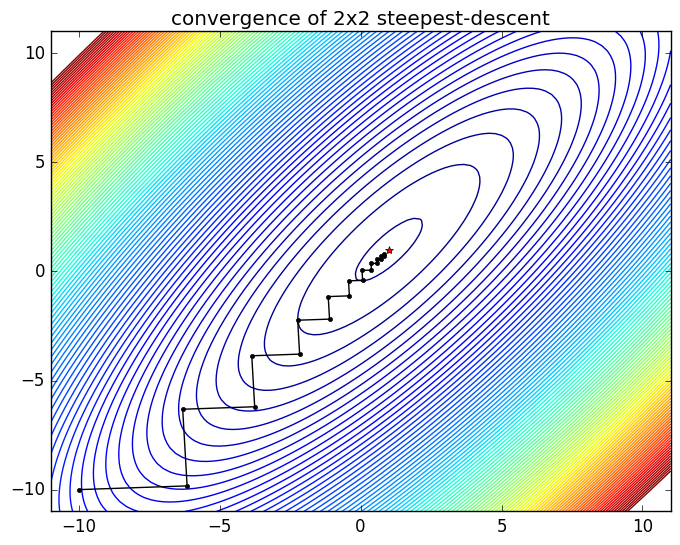

PyObject <matplotlib.text.Text object at 0x32a577fd0>

In [108]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = linspace(-11,11,100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=linspace(1,2000,100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x, = SD(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 steepest-descent")

The solution "zig-zags" down the long, narrow valley defined by the quadratic function `f`.  This is a common problem of steepest-descent algorithms: they tend to go towards the center of valleys (down the "steep" direction), rather than *along* the valleys towards the solution.

To fix this problem, basically we need to implement some kind of "memory": it has to "remember" that it just "zigged" in order to avoid "zagging" back where it came from.  

## From steepest-descent to conjugate-gradient

The most famous way to improve steepest descent with "memory" is the [conjugate-gradient algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method).  I won't explain it here ([Shewchuk's article](http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) is a good introduction to its relationship to steepest descent), but the implementation ends up being *almost identical* to steepest descent.  However, instead of setting the line-search direction equal to the downhill direction `r`, the line-search direction is instead a linear combination of `r` with the *previous* search direction:

In [52]:
function CG(A, b, x=zeros(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    d = copy(r) # initial direction is just steepest-descent
    Ad = zeros(r) # allocate space for Ad
    for i = 1:maxiters
        A_mul_B!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        d .= r .+ d .* (rnorm[end]/rnorm[end-1])^2 # conjugate direction update
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

CG (generic function with 2 methods)

In [53]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, rnorm = CG(A, b)
length(rnorm), rnorm[end]/norm(b)

(197,5.822565694881327e-9)

After some initial slow progress, the conjugate-gradient algorithm quickly zooms straight to the solution:

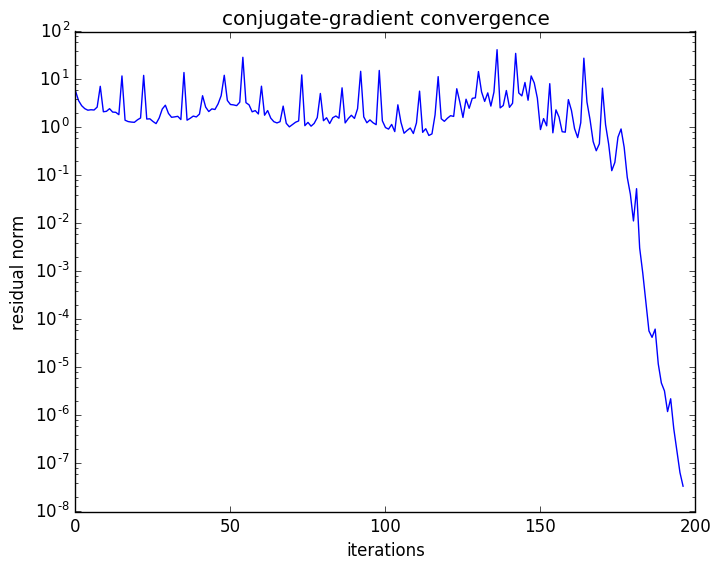

PyObject <matplotlib.text.Text object at 0x322087450>

In [54]:
semilogy(rnorm)
title("conjugate-gradient convergence")
ylabel("residual norm")
xlabel("iterations")

In our 2x2 problem, you can see that it actually converges in **two steps**:

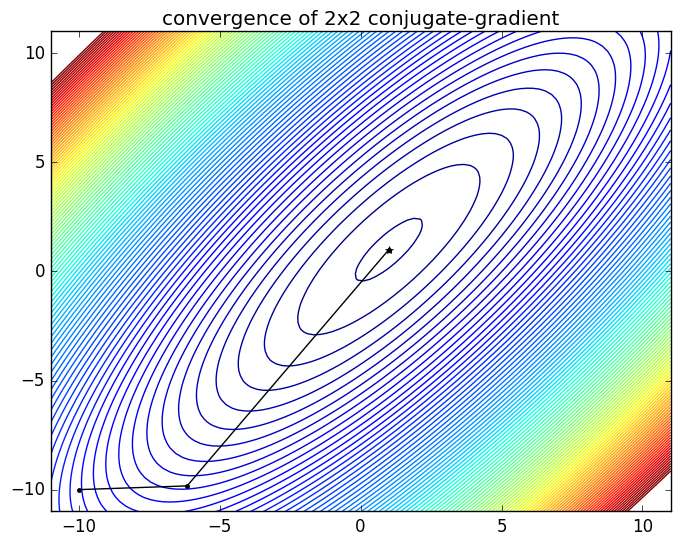

PyObject <matplotlib.text.Text object at 0x32b47f750>

In [109]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b = A * [1,1] # right-hand side for solution (1,1)
x1 = linspace(-11,11,100)
contour(x1', x1, [dot([x1,x2], A*[x1,x2]) - 2*(x1*b[1]+x2*b[2]) for x1 in x1, x2 in x1], levels=linspace(1,2000,100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:2
    x, = CG(A, b, [-10.,-10.], maxiters=i)
    push!(x1s, x[1])
    push!(x2s, x[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 conjugate-gradient")

## You don't have to write your own iterative solvers

There are several packages out there with iterative solvers that you can use, e.g. the [IterativeSolvers](https://github.com/JuliaMath/IterativeSolvers.jl) package:

In [56]:
# do this if you haven't installed it yet: Pkg.add("IterativeSolvers")
using IterativeSolvers

In [57]:
A = rand(100,100); A = A'*A # a random SPD matrix
b = rand(100)
x, ch = cg(A, b, maxiter=300)
norm(A*x - b) / norm(b)

5.6808013906906684e-12

In [58]:
dump(ch)

IterativeSolvers.ConvergenceHistory{Float64,Array{Float64,1}}
  isconverged: Bool false
  threshold: Float64 1.3074561446385202e-13
  mvps: Int64 301
  residuals: Array{Float64}((300,)) [3.45965,3.01715,2.70492,2.97681,2.84608,2.83556,2.81886,8.60126,2.73169,2.40031  …  4.70599e-12,7.71401e-12,4.57879e-12,3.93746e-12,9.59423e-12,3.93631e-12,2.49173e-12,3.05229e-12,2.01123e-12,4.15111e-12]


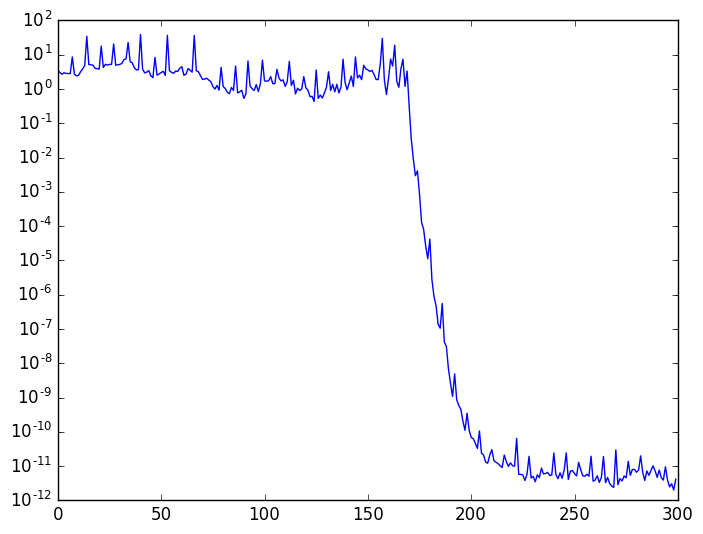

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322fd0ed0>

In [59]:
semilogy(ch.residuals)

### PETSc

[PETSc.jl](https://github.com/JuliaParallel/PETSc.jl) provides a Julia interface to the PETSc library: large-scale iterative and sparse solvers for distributed-memory parallel systems.  It is a bit harder to use, because it expects you to set up its own kind of sparse matrix that works on distributed-memory systems.

## Preconditioners

Most iterative solvers are *greatly accelerated* if you can provide a *preconditioner*: roughly, an *approximate inverse* of $A$ that is *easy to compute*.  The preconditioner is applied at *every step* of the iteration in order to speed up convergence.

For example, let's consider a problem where the matrix $M = L + A$ is a sum of the symmetric-tridiagonal discrete Laplacian $L$ (from above) and a *small, sparse* perturbation $A$.  As our preconditioner, we'll simply use $L$, since this is a good approximation for $M$ and $L \ b$ is fast (linear time):

In [115]:
n = 300
L = SymTridiagonal(diagm(ones(n)*2) - diagm(ones(n-1),-1) - diagm(ones(n-1), 1))
b = rand(n)

A = sprand(n,n,0.001) * 0.001

M = sparse(L + A)

300×300 sparse matrix with 1010 Float64 nonzero entries:
	[1  ,   1]  =  2.0
	[2  ,   1]  =  -1.0
	[164,   1]  =  0.000497291
	[260,   1]  =  0.000116723
	[1  ,   2]  =  -1.0
	[2  ,   2]  =  2.0
	[3  ,   2]  =  -1.0
	[2  ,   3]  =  -1.0
	[3  ,   3]  =  2.0
	[4  ,   3]  =  -1.0
	⋮
	[297, 297]  =  2.0
	[298, 297]  =  -1.0
	[297, 298]  =  -1.0
	[298, 298]  =  2.0
	[299, 298]  =  -1.0
	[298, 299]  =  -1.0
	[299, 299]  =  2.0
	[300, 299]  =  -1.0
	[122, 300]  =  0.000558164
	[299, 300]  =  -1.0
	[300, 300]  =  2.0

Our home-brewed `CG` function above does not accept a preconditioner, but the IterativeSolvers package `cg` function does, and it makes a *huge* difference in the convergence:

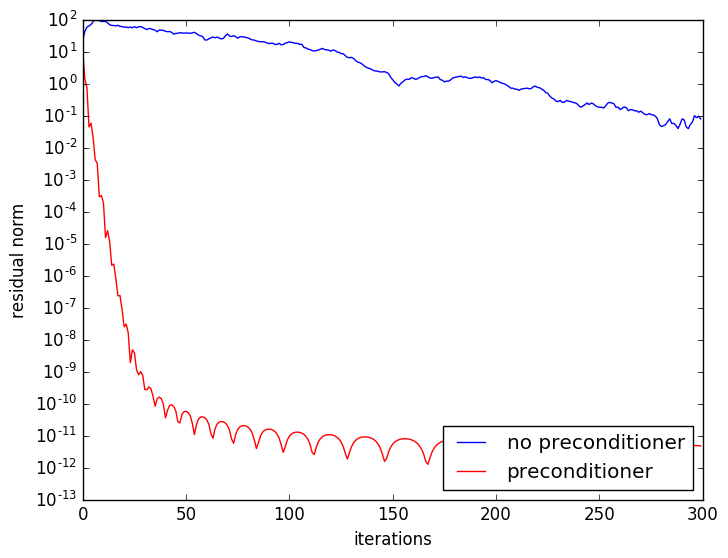

PyObject <matplotlib.legend.Legend object at 0x32bf00610>

In [116]:
x, ch = cg(M, b, maxiter=300)
x′, ch′ = cg(M, b, L, maxiter=300)
semilogy(ch.residuals, "b-")
semilogy(ch′.residuals, "r-")
xlabel("iterations")
ylabel("residual norm")
legend(["no preconditioner", "preconditioner"], loc="lower right")

If you can find a good preconditioner, you can often speed things up by orders of magnitude.  Unfortunately, finding preconditioners is hard and problem-dependent.  There are some general "recipes" for things to try, but there are many problems (like the scalar-Helmholtz problem above) where good preconditioners are still an open research problem